In [190]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import imageio
import matplotlib.image as mpimg
import tifffile
from torch import nn
import torchvision
from torchvision.transforms import v2

In [164]:
def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext == ".tif":
        tif_data = tifffile.imread(filename)[:,:,0]
        return tif_data
    elif ext == ".png":
        return np.array(Image.open(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        return Image.open(filename)

In [172]:
def generate_gradient(shape: tuple[int, int]) -> np.ndarray:              
    
    '''
    Inputs in format (H, W)
    Outputs a gradient from 0 to 1 in both x and y directions
    Channel 0 gradient on W and Channel 1 gradient on H
    '''
    
    xx, yy = np.meshgrid(np.linspace(0, 1, shape[1]), np.linspace(0, 1, shape[0]))
    gradient = np.stack([xx, yy], axis=-1)
    return gradient

In [173]:
def get_input_data(filename) -> np.ndarray: 
    
    '''
    Load image from filename (tiff, png, npy, pt) and generates the gradient on the size of the image
    Concatenate them and return the result in np.array
    (H, W, C), C = 2
    '''
    
    data = load_image(filename)
    gradient = generate_gradient(data.shape)[:,:,1]
    return np.concatenate([np.expand_dims(data, axis=2), np.expand_dims(gradient, axis=2)], axis=2)

In [144]:
def unique_mask_values(idx, mask_dir, mask_suffix):
    
    
    '''
    Return the unique values of a mask
    '''

    try:
        mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))[0]        # Use the first sample 
    
    except IndexError:
        raise FileNotFoundError(f'No mask file found for image {idx}')
    
    mask = np.asarray(load_image(mask_file))
    if mask.ndim == 2:
        return np.unique(mask)
    elif mask.ndim == 3:
        mask = mask.reshape(-1, mask.shape[-1])
        return np.unique(mask, axis=0)
    else:
        raise ValueError(f'Loaded masks should have 2 or 3 dimensions, found {mask.ndim}')

In [75]:
data_filename = "data/images/train/il_0.tif"
mask_filename = "data/annotations/train/il_0.png"

In [175]:
mask = load_image(mask_filename)
mask[:,:].shape

(255, 701)

In [176]:
teste = get_input_data(data_filename)
teste[:,:,0], teste[:,:,1], type(teste), teste[:,:,0].shape

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00829577,  0.00636416,  0.00370673, ..., -0.04055443,
         -0.0451528 , -0.04827393],
        [ 0.0501296 ,  0.04737168,  0.02804823, ..., -0.23444323,
         -0.25487701, -0.26996967],
        ...,
        [ 0.24166922,  0.12021541,  0.13181945, ...,  0.06050743,
          0.06330186,  0.05875252],
        [ 0.24751962,  0.13917661,  0.14523736, ...,  0.0554414 ,
          0.06327252,  0.06000922],
        [ 0.24751962,  0.13917661,  0.14523736, ...,  0.0554414 ,
          0.06327252,  0.06000922]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00393701, 0.00393701, 0.00393701, ..., 0.00393701, 0.00393701,
         0.00393701],
        [0.00787402, 0.00787402, 0.00787402, ..., 0.00787402, 0.00787402,
         0.00787402],
        ...,
        [0.99212598, 0.99212598, 0.99212598, ..., 0.99212598, 0.99212598

In [163]:
teste[:,:,1].max(), teste[:,:,1].min()

(1.0, 0.0)

In [ ]:
# def reshape_input_data(data):
#     desired_height = 256
#     data = torch.tensor(data).permute(2, 0, 1)
#     padded_image = nn.functional.pad(data, pad=(0, 0, 0,desired_height-data.shape[0]), mode='replicate')
#     return padded_image

# padded_image = reshape_input_data(teste)
# padded_image[1,:,:],padded_image[0,:,:], padded_image.shape

In [160]:
# padded_image[0,:,:].max(), padded_image[0,:,:].min()

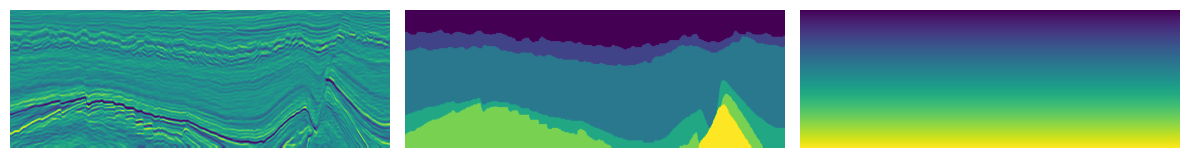

In [171]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(teste[:,:,0])
axs[1].imshow(img)
axs[2].imshow(teste[:,:,1])

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [177]:
class Dataset(Dataset):
    def __init__(self, data_dir: str, mask_dir: str, transform=None):
        
        # Data and mask directories
        self.data_dir = Path(data_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform

        # Get the ids of the train data
        self.ids = [splitext(file)[0] for file in listdir(data_dir) if isfile(join(data_dir, file)) and not file.startswith('.')]

        if not self.ids:
            raise RuntimeError(f'No input file found in {data_dir}, make sure you put your images there')
        
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')

        with Pool() as p:
            unique = list(tqdm(
                p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                total=len(self.ids)
            ))

        self.mask_values = list(sorted(np.unique(np.concatenate(unique), axis=0).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')

        def __len__(self):
            return len(self.ids)    
        
        @staticmethod
        def preprocess(img, mask_values, is_mask):
            
            if is_mask:
                mask = np.zeros(img.size, dtype=np.int64)
                for i, v in enumerate(mask_values):
                    mask[img == v] = i
        
            else:
                if img.ndim == 2:
                    img = img[np.newaxis, ...]
                else:
                    img = img.transpose(2, 0, 1)
                    
                if (img > 1).any():
                    img = img / 255
        
            return img
        
        def __getitem__(self, idx):
            name = self.ids[idx]
            mask_file = list(self.mask_dir.glob(name + '.*'))
            data_file = list(self.data_dir.glob(name + '.*'))
            
            assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
            assert len(data_file) == 1, f'Either no image or multiple images found for the ID {name}: {data_file}'
            
            mask = load_image(mask_file[0])                 # Máscara
            data = get_input_data(data_file[0])             # Dado com o gradiente
            
            assert data.shape[:,:,0] == mask.shape, \
                'Image and mask should be the same size, but are {}(data) and {}(mask)'.format(data.shape, mask.shape)
                
            mask = self.preprocess(mask, self.mask_values, is_mask=True)
            data = self.preprocess(data, self.mask_values, is_mask=False)
            
            # TODO
            # Aplica a transformação (aumentação) e conversão pra Tensor
            
            # return {
            #     'image': torch.from_numpy(data).type(torch.FloatTensor),
            #     'mask': torch.from_numpy(mask).type(torch.LongTensor)
            # }

            # Já convertidos para Tensor pelo transforms
            return {
                'image': data,
                'mask': mask
            }
            
            

In [200]:
from torchvision.transforms import v2

from torchvision import transforms

transform = v2.Compose([
    
    # Transforms a Tensor type from the beggining of the pipeline
    transforms.ToTensor(),
    
    # Cropping the image in a random location so Inlines and Crosslines can be used together 
    transforms.RandomCrop(size=256, pad_if_needed=True, padding_mode='symmetric'), 
    
    # Random Flip with 50% chance
    transforms.RandomHorizontalFlip(),
    
    # Don't know if the autor meant to rotate from 0 to 5 or -5 to 5. Using -5 to 5 for now.
    # Also don't know what would fill the gaps in the image after rotation. Believing that Torch will handle it
    transforms.RandomRotation(degrees=(-5, 5))
    
    # TODO
    # Apply " domain-specific image warping technique, which simulates geologic faults and folding"
    
])

In [ ]:
# teste[:,:,0], teste[:,:,1], mask

import torchvision.tv_tensors


transformed_data, (transformed_mask) = transform(teste, torchvision.tv_tensors.Mask(mask))

# transformed_data, transformed_mask



In [ ]:
import torch
from torchvision import transforms

class CustomTransform(transforms.Transform):
    def __init__(self):
        super().__init__()

    def __call__(self, image, mask):
        # Apply transformations to the image and mask
        # ...

        return transformed_image, transformed_mask

# Create an instance of the custom transform
custom_transform = CustomTransform()


In [ ]:
from torchvision.transforms import Compose, ToTensor

class ImageMaskCompose:
    def __init__(self, image_transforms, mask_transforms):
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)
        return {'image': image, 'mask': mask}

# Define image transforms
image_transforms = Compose([
    # Add your desired image transforms here
    ToTensor()
])

# Define mask transforms
mask_transforms = Compose([
    # Add your desired mask transforms here
    ToTensor()
])

# Create the transform compose
transform = ImageMaskCompose(image_transforms, mask_transforms)
